<a href="https://colab.research.google.com/github/BehNas/marathon_machine_learning/blob/master/cylinder%20bands_rotogravure_printing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


Accuracy: 0.7523809523809524


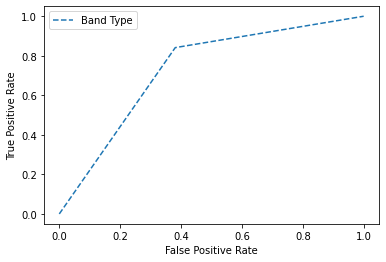

Type Band: f1=0.803 auc=0.730


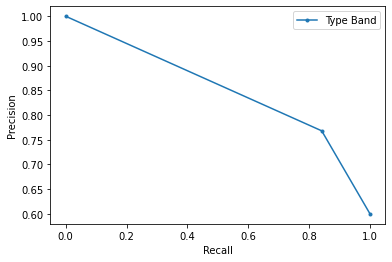

fpr:  [0.         0.38095238 1.        ] tpr:  [0.         0.84126984 1.        ] auc:  <function auc at 0x7ff86b337b70> f1:  0.8030303030303031 prec [0.6        0.76811594 1.        ] recall [1.         0.84126984 0.        ]


In [ ]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import f1_score


path_data = '/content/drive/My Drive/Colab Notebooks/screen_test/bands.data'
path_names = '/content/drive/My Drive/Colab Notebooks/screen_test/bands.names'
missing_value_formats = ["None","?","NA","n/a", "na", "--"]
with open(path_data) as fp:
    data = [line.split(maxsplit=40) for line in fp]
# print(data)
total_data = []
length = len(data)

for i in range(len(data)):
  d = data[i]
  if d:
    temp = d[0].split(',')
    total_data.append(temp)

df = pd.DataFrame(total_data)
df.columns = ['timestamp', 'cylinder number', 'customer', 'job number', 'grain screened', 'ink color', 'proof on ctd ink', 'blade mfg', 'cylinder division', 'paper type', 'ink type', 'direct steam', 'solvent type', 'type on cylinder', 'press type', 'press', 'unit number', 'cylinder size', 'paper mill location', 'plating tank', 'proof cut', 'viscosity', 'caliper', 'ink temperature', 'humifity', 'roughness', 'blade pressure', 'varnish pct', 'press speed', 'ink pct', 'solvent pct', 'ESA Voltage', 'ESA Amperage', 'wax', 'hardener', 'roller durometer', 'current density', 'anode space ratio', 'chrome content', 'band type']

# drop the intances which has more than 13 unknown features
for i in range (len(total_data)):
  count = 0
  for item in df.columns:
    if df.at[i, item] == '?':
      count += 1
    if type(df.at[i, item]) == str:
      df.at[i, item] = df.at[i, item].upper()
  if count > 13:
    df.at[i, item] = np.nan
# for i in len(df[['timestamp']]):

# drop None rows
df = df.replace(to_replace='None', value=np.nan).dropna()

# convert to numeric
df.loc[df[df.columns[4]] == 'YES', df.columns[4]] = 1
df.loc[df[df.columns[6]] == 'YES', df.columns[6]] = 1
df.loc[df[df.columns[11]] == 'YES', df.columns[11]] = 1
df.loc[df[df.columns[13]] == 'YES', df.columns[13]] = 1
df.loc[df[df.columns[4]] == 'NO', df.columns[4]] = 0
df.loc[df[df.columns[6]] == 'NO', df.columns[6]] = 0
df.loc[df[df.columns[11]] == 'NO', df.columns[11]] = 0
df.loc[df[df.columns[13]] == 'NO', df.columns[13]] = 0
df.loc[df[df.columns[11]] == 'USE', df.columns[11]] = 1
df.loc[df[df.columns[13]] == 'YES', df.columns[13]] = 1

# drop identifier columns
del df['job number']
del df['customer']
del df['cylinder number']
del df['paper mill location']
# drop the inke color since all the data set has same KEY
del df['ink color']
del df['cylinder division']

# interpolate binaries
binary = ['grain screened','proof on ctd ink','direct steam','type on cylinder']
for columns in binary:
  count = df[columns].value_counts()
  if count[0] >= count[1]:
    df.loc[df[columns] == '?', columns] = 0
  else:
    df.loc[df[columns] == '?', columns] = 1
df['direct steam'] = pd.to_numeric(df['direct steam'])
df['grain screened'] = pd.to_numeric(df['grain screened'])
df['proof on ctd ink'] = pd.to_numeric(df['proof on ctd ink'])
df['type on cylinder'] = pd.to_numeric(df['type on cylinder'])

# convert to numeric 

df['press'] = pd.to_numeric(df['press'])
df['unit number'] = pd.to_numeric(df['unit number'])

mean_press = df['press'].mean()
df.loc[df['press'] == '?', 'press'] = round(mean_press)

mean_unit = df['unit number'].mean()
df.loc[df['unit number'] == '?', 'unit number'] = round(mean_unit)

count1 = df['plating tank'].value_counts()
if count1[0] >= count1[1]:
  df.loc[df['plating tank'] == '?', 'plating tank'] = '1910'
else:
  df.loc[df['plating tank'] == '?', 'plating tank'] = '1911'

df['plating tank'] = pd.to_numeric(df['plating tank'])

# interpolate all numerics 
df2 = df
df2 = df2.replace(to_replace='?', value=np.nan).dropna()
for column in df.columns[14:33]:
  df2[column] = pd.to_numeric(df2[column])
  mean = df2[column].mean()
  df.loc[df[column] == '?', column] = round(mean)
  df[column] = pd.to_numeric(df[column])

df2['timestamp'] = pd.to_numeric(df2['timestamp'])
mean = df2['timestamp'].mean()
df.loc[df['timestamp'] == '?', 'timestamp'] = round(mean)
df['timestamp'] = pd.to_numeric(df['timestamp'])
# --------------------------------------------------------------------------------------
# sns.catplot(x="press type", y="timestamp", hue="band type", kind="box", data=df)
# sns.boxplot(x="blade mfg",y="roller durometer",hue="band type",data=df, palette="coolwarm")
# --------------------------------------------------------------------------------------
# g= sns.pairplot(df,hue = 'band type', kind= 'scatter',
#              vars=df.columns[16:20],
#              plot_kws=dict(alpha=0.5),
#              diag_kws=dict(alpha=0.5))
# plt.show()
# ----------------------------------------------------------------------------------------
# replace all the missing values with most freaquent one in categorical value
nominal_columns = list(set(df.columns) - set(df._get_numeric_data().columns))
for columns in nominal_columns:
  values = df[columns].value_counts().keys().tolist()
  # counts = columns.value_counts().tolist()
  df.loc[df[columns] == '?', columns] = values[0]
# -----------------------------------------------------------------------------------------
# df.loc[df['band type'] == 'BAND', 'band type'] = 1
# df.loc[df[df.columns[33]] == 'NOBAND', df.columns[33]] = 0
label_encoder = LabelEncoder()
df["band type"] = label_encoder.fit_transform(df["band type"])
df['band type'] = pd.to_numeric(df['band type'])
df["ink type"] = label_encoder.fit_transform(df["ink type"])
df['ink type'] = pd.to_numeric(df['ink type'])
df["paper type"] = label_encoder.fit_transform(df["paper type"])
df['paper type'] = pd.to_numeric(df['paper type'])
df["blade mfg"] = label_encoder.fit_transform(df["blade mfg"])
df['blade mfg'] = pd.to_numeric(df['blade mfg'])
df["solvent type"] = label_encoder.fit_transform(df["solvent type"])
df['solvent type'] = pd.to_numeric(df['solvent type'])
df["cylinder size"] = label_encoder.fit_transform(df["cylinder size"])
df['cylinder size'] = pd.to_numeric(df['cylinder size'])
df["press type"] = label_encoder.fit_transform(df["press type"])
df['press type'] = pd.to_numeric(df['press type'])
# display(HTML(df.to_html()))
df_X = df.iloc[:, 0:32]
df_Y = df.iloc[:, 33]
x_train, x_test, y_train, y_test = train_test_split(df_X, df_Y, stratify=df_Y, test_size=0.20)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test) 
y_probs = clf.predict_proba(x_test)
# score = score(x_test, y_pred)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print(y_probs)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
lr_auc = roc_auc_score(y_test, y_pred)
# print('AUC: %.3f' % auc)
pyplot.plot(fpr, tpr, linestyle='--', label='Band Type')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_probs = y_probs[:, 1]
# predict class values
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_probs)
lr_f1 = f1_score(y_test, y_pred)

# summarize scores
print('Type Band: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
# no_skill = len(y_test[y_test==1]) / len(y_test)
# pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Type Band')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Type Band')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print("fpr: ", fpr, "tpr: ", tpr, "auc: ", auc, "f1: ", f1, "prec", precision, "recall", recall)
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# fpr[0], tpr[0], _ = roc_curve(y_test[:, 0], y_pred[:, 0])
# roc_auc[0] = auc(fpr[0], tpr[0])                                    
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# plt.figure()                                      
